In [18]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Evolution algorithm parameters
population_size = 30
num_generations = 3

# Define the dataset (dummy data for demonstration)
# X1: Input features, y1: Target labels
np.random.seed(42)
num_samples = 100000
X1 = np.random.rand(num_samples, 2).astype(np.float32)
y1 = (X1[:, 0] * X1[:, 1]).reshape(-1, 1).astype(np.float32)
#X1 = torch.rand((num_samples, 2))
#y1 = torch.prod(X1, dim=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X1, y1, test_size=0.2, random_state=42, shuffle=True)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)
X_val_tensor = torch.tensor(X_val, device=device)
y_val_tensor = torch.tensor(y_val, device=device)

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer with 128 units
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 units
        self.fc3 = nn.Linear(64, 32) 
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8) 
        self.fc6 = nn.Linear(8, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Define the fitness function
def evaluate_model(m):
    # Training loop
    num_epochs = 100
    perm = torch.randperm(X_train_tensor.size(0))
    shuffled_X = X_train_tensor[perm]
    shuffled_y = y_train_tensor[perm]
    for epoch in range(num_epochs):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        outputs = m(shuffled_X)
        # calculate loss
        loss = criterion(outputs, shuffled_y)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

    perm = torch.randperm(X_val_tensor.size(0))
    shuffled_X = X_val_tensor[perm]
    shuffled_y = y_val_tensor[perm]
    m.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predicted = m(shuffled_X)
        loss = criterion(predicted, shuffled_y)

    differences = torch.abs(predicted - shuffled_y)
    total_difference = torch.sum(differences).item()
    return total_difference

def create_child_with_mutation(parent):
    # Create a permutation index to shuffle the data
    perm = torch.randperm(X_train_tensor.size(0))

    shuffled_X = X_train_tensor[perm]
    shuffled_y = y_train_tensor[perm]

    # Clone the parent model and move it to the same device
    child_model = copy.deepcopy(parent)
    child_model.to(X_train_tensor.device)

    op = optim.Adam(x_model.parameters(), lr=0.01)
    # Perform a gradient descent step on the child model using the provided data
    op.zero_grad()
    child_outputs = child_model(shuffled_X)
    child_loss = criterion(child_outputs, shuffled_y)
    child_loss.backward()
    op.step()

    return child_model

def create_initial_population(parent_model):
    population = []
    population.append(parent_model)  # Include the parent model in the population
    for _ in range(population_size - 1):
        population.append(create_child_with_mutation(parent_model))  # Append the child model to the population

    return population

# Create an instance of the model and move it to GPU if available
x_model = SimpleNN(2, 128, 1).to(device)
criterion = nn.MSELoss()  # Use Mean Squared Error for regression
optimizer = optim.Adam(x_model.parameters(), lr=0.001)

# Check if the model file exists
model_file = "model_multiplier.pth"
if os.path.exists(model_file):
    try:
        x_model.load_state_dict(torch.load(model_file))
        print("Model loaded successfully.")
    except:
        print("Error loading model.")
else:
    print("Model file not found. Creating a new model.")

# Initialize the population with random model architectures
population = create_initial_population(x_model)

# Evolution loop
for idx, generation in enumerate(range(num_generations)):
    # Evaluate fitness for each model
    fitness_scores = [evaluate_model(m) for m in population]
    print(f'Generation {idx}/{num_generations} - {len(population)}')
    print(f'Score {fitness_scores}')

    # Select top-performing models
    num_selected = int(0.2 * population_size)

    # negative values, closer to 0 is better
    selected_indices = np.argsort(fitness_scores)[:num_selected]

    # Create new generation through mutation and crossover
    new_population = [population[i] for i in selected_indices]
    while len(new_population) < population_size:
        parentIndex = np.random.choice(selected_indices)
        new_population.append(create_child_with_mutation(population[parentIndex]))

    population = new_population

# Select the best model from the final population
best_model = min(population, key=lambda model: evaluate_model(model))
#print("Best Model:", best_model)
torch.save(best_model.state_dict(), 'model_multiplier.pth')

Using device: cuda
Model loaded successfully.
Generation 0/3 - 30
Score [17.84097671508789, 18.291778564453125, 18.291776657104492, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291776657104492, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291776657104492, 18.291776657104492, 18.291778564453125, 18.291778564453125, 18.291778564453125]
Generation 1/3 - 30
Score [16.927833557128906, 18.291778564453125, 18.291778564453125, 18.291778564453125, 18.291776657104492, 18.291778564453125, 17.840974807739258, 18.291776657104492, 18.291778564453125, 18.291778564453125, 18.291778564453125, 17.84097671508789, 18.291778564453125, 18.291776657104492, 18.291778564453125, 18

diff: 0.0004
diff: 0.0015
diff: 0.0014
diff: -0.0019
diff: 0.0000


C:\Users\Admin\AppData\Local\Temp\ipykernel_24420\1788194770.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"diff: {(float(expected_result) - float(predicted_result)):.4f}")


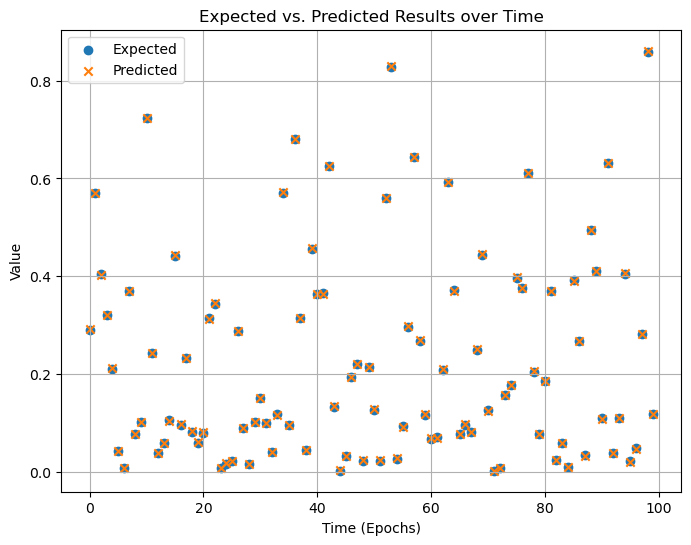

In [19]:
import matplotlib.pyplot as plt  # Import the matplotlib.pyplot module

model = best_model
# Generate a new test dataset
X_test = np.random.rand(100, 2).astype(np.float32)
y_test = X_test.prod(axis=1)

# Convert the test data to PyTorch tensors and move to GPU if available
X_test_tensor = torch.tensor(X_test, device=device)

# Run predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_y = model(X_test_tensor)

# Move predictions and ground truth back to CPU for plotting
predicted_y = predicted_y.cpu().numpy()

# Print expected and predicted results along with their corresponding multipliers
for i in range(len(X_test)-5,len(X_test)):
    multiplier1, multiplier2 = X_test[i]
    expected_result = y_test[i]
    predicted_result = predicted_y[i]
    print(f"diff: {(float(expected_result) - float(predicted_result)):.4f}")

# Create a plot with time (epochs) on the x-axis and both expected and predicted values as individual balls
plt.figure(figsize=(8, 6))
plt.scatter(range(len(X_test)), y_test, label='Expected', marker='o')
plt.scatter(range(len(X_test)), predicted_y, label='Predicted', marker='x')
plt.xlabel("Time (Epochs)")
plt.ylabel("Value")
plt.title("Expected vs. Predicted Results over Time")
plt.grid(True)
plt.legend()
plt.show()